In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

length = 429.98331198338406


<Figure size 1080x648 with 0 Axes>

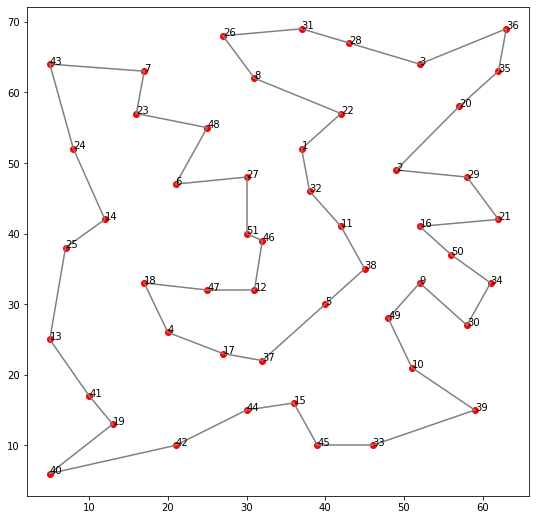

In [4]:

nodes = np.loadtxt('TSP/eil51.tsp.txt', skiprows = 6, max_rows = 51)
opt_tour = np.loadtxt('TSP/eil51.opt.tour.txt', skiprows = 5, max_rows = 51)

d_nodes = {}
for node in nodes: 
    d_nodes[node[0]] = (node[1], node[2])

def plotnodes(nodes): 
    plt.figure(figsize = (9,9))
    for node in nodes:
        plt.plot(node[1], node[2], 'ro')
        plt.annotate(int(node[0]), (node[1], node[2]))

def plotedges(tour): 

    for i, node in enumerate(tour):
        
        if i >= len(tour) - 1: 

            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]

        x_coords = [x1,x2]
        y_coords = [y1,y2]

        plt.plot(x_coords, y_coords, color = 'grey')

def tour_length(tour):
    total_length_manual = 0

    for i, node in enumerate(tour):
        
        if i >= len(tour) - 1: 

            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]

       
        length_manual = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
        
        total_length_manual += length_manual
    return total_length_manual

plt.figure(figsize = (15,9))
plotnodes(nodes)
plotedges(opt_tour)
print('length = ' + str(tour_length(opt_tour)))




In [113]:

def make_d_nodes(nodes): 
    
    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])
    return d_nodes

def make_tour_edges(tour): 
    tour_edges = []

    for i, node in enumerate(tour):
        if i < len(opt_tour) - 1: 
            tour_edges.append([node, tour[i+1]])
        else:
            tour_edges.append([node, tour[0]])
    
    return tour_edges

def make_distance_matrix(d_nodes, n_nodes):
        
    distance_matrix = np.zeros((n_nodes,n_nodes))
    for node1 in range(n_nodes):
        for node2 in range(n_nodes): 
            
            x1 = d_nodes[node1+1][0]
            x2 = d_nodes[node2+1][0]
            y1 = d_nodes[node1+1][1]
            y2 = d_nodes[node2+1][1]
            distance_matrix[node1, node2] = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
    
    return distance_matrix
    

def comp_length_from_matrix(tour, distance_matrix):

    tour_edges = make_tour_edges(tour)
    total_distance = 0
    for edge in tour_edges: 
        
        total_distance += distance_matrix[int((edge[0] - 1)), int((edge[1] - 1))]
    return total_distance

def make_random_route(n_nodes):
    l_nodes = np.arange(1,n_nodes+1)
    return np.random.permutation(l_nodes)
    



<Figure size 1080x648 with 0 Axes>

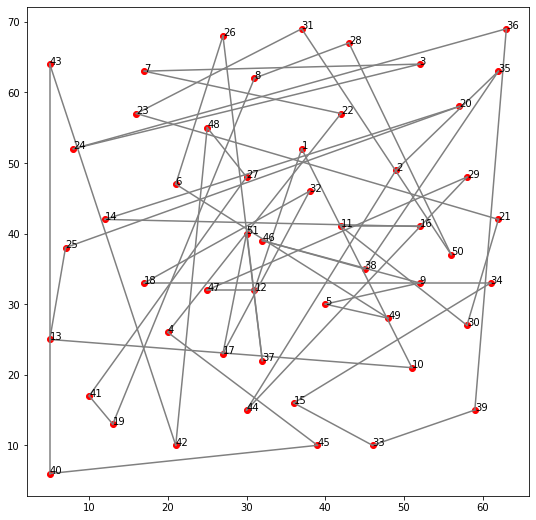

Length of tour = 1553.815483918357


In [66]:

n_nodes = 51
distance_matrixeil51 = make_distance_matrix(d_nodes, 51)

random_route = make_random_route(51)

plt.figure(figsize = (15,9))
plotnodes(nodes)
plotedges(random_route)
plt.show()

print(f'Length of tour = {comp_length_from_matrix(random_route, distance_matrixeil51)}')

tour = np.arange(1, 6)
def lin2opt(tour): 
    # apply lin 2 opt to tour
    n_nodes = len(tour)
    rand_node1 = np.random.randint(1, n_nodes+1)
    rand_node2 = np.random.randint(1, n_nodes+1)


    i_rand_node1 = np.argwhere(tour == rand_node1)[0][0]
    i_rand_node2 = np.argwhere(tour == rand_node2)[0][0]

    tour2 = np.copy(tour)

    subtour = tour2[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)]
    flipped_subtour = np.flip(subtour)

    tour2[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)] = flipped_subtour
    return tour2





In [114]:
# load in a280, make sure the correct d_nodes is a global variable with that name
a280nodes = np.loadtxt('TSP/a280.tsp.txt', skiprows = 6, max_rows = 280)
a280opt_tour = np.loadtxt('TSP/a280.opt.tour.txt', skiprows = 4, max_rows = 280)
d_nodes = make_d_nodes(a280nodes)
distance_matrixa280 = make_distance_matrix(d_nodes, 280)
print(f'Length of optimal tour for a280 = {comp_length_from_matrix(a280opt_tour, distance_matrixa280)}')


20.0
Length of optimal tour for a280 = 43219.91311500716


In [115]:
# Simulated annealing, taken from the Natural Solvers paper
# 200 Markov chains of length 500
# Cooling schedule: constant temperature decrement with cr = 0.975
# Initial c = 0.3
# To switch from TSP problem instances, load in the desired .txt files, set n_nodes to the number
# of nodes in the problem, and chance the distance matrix argument in the comp_length_from_matrix() function
cr = 0.975
c_i = 0.3
n_chains = 200
mc_length = 500
n_nodes = 280

c_schedule = [c_i]
for i in range(n_chains - 1):
    c_i = cr * c_i
    c_schedule.append(c_i)   


initial_tour = make_random_route(n_nodes)
tour_i = initial_tour
cost_i = comp_length_from_matrix(initial_tour, distance_matrixa280)
# print('Length of initial tour = ' + str(cost_i))

l_costi = []
chain = 0
for c in c_schedule:
    chain += 1
    print(chain)
    for _ in range(mc_length):
        
        tour_j = lin2opt(tour_i)
        cost_i = comp_length_from_matrix(tour_i, distance_matrixa280)
        cost_j = comp_length_from_matrix(tour_j, distance_matrixa280)

        A_ij = min(1, np.exp(-(cost_j - cost_i) / c))

        if A_ij == 1: 
            tour_i = tour_j
        else:
            r = np.random.uniform()
            if A_ij >= r: 
                tour_i = tour_j

        l_costi.append(cost_i)
    




1


C:\Users\danie\AppData\Local\Temp/ipykernel_9656/1685820932.py:33: RuntimeWarning: overflow encountered in exp
  A_ij = min(1, np.exp(-(cost_j - cost_i) / c))


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


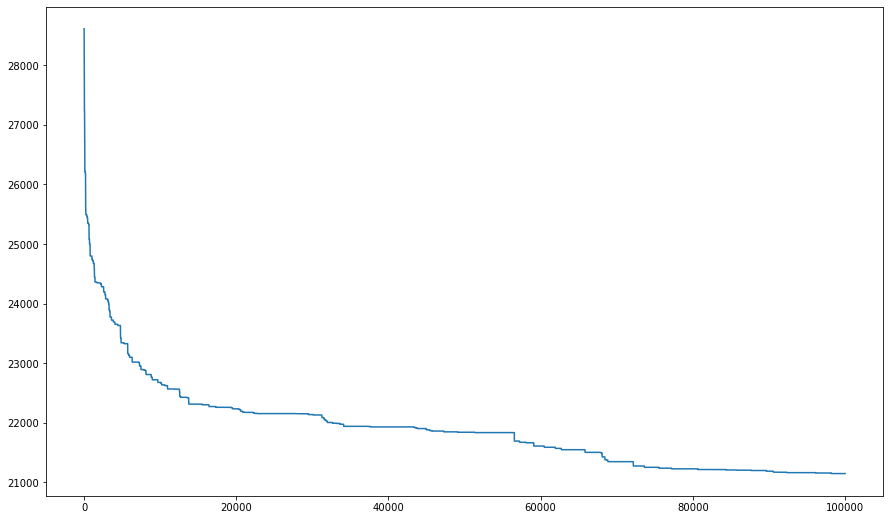

<Figure size 1080x648 with 0 Axes>

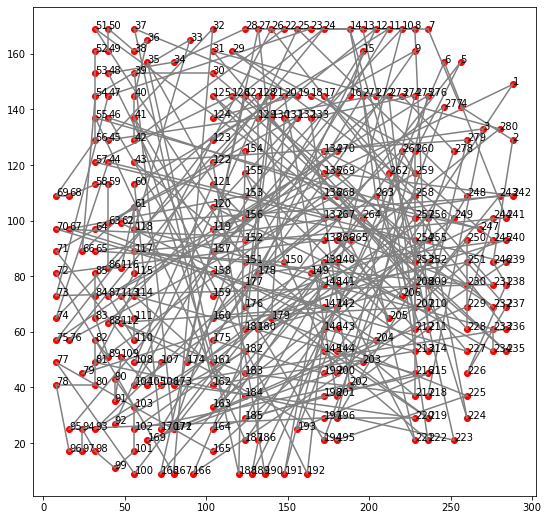

length = 21147.01002114254


C:\Users\danie\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danie\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


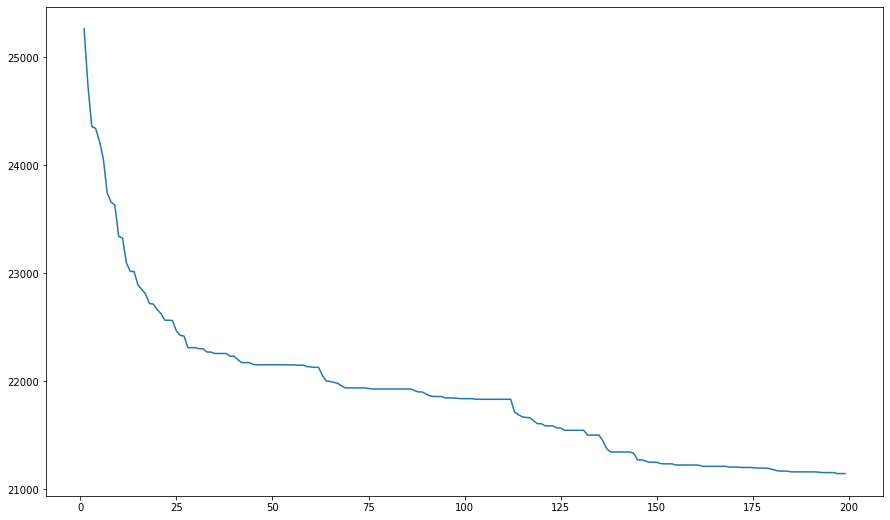

In [117]:
plt.figure(figsize = (15,9))
plt.plot(np.arange(1, (n_chains * mc_length) + 1), l_costi)
plt.show()

plt.figure(figsize = (15,9))
plotnodes(a280nodes)
plotedges(tour_i)
plt.show()
print(f'length = {cost_i}')

averages = []
chains = []
for i, c in enumerate(c_schedule): 
    chains.append(i+1)
    averages.append(np.mean(l_costi[int(mc_length*(i+1)):int(mc_length*(i+1) + 200)]))

plt.figure(figsize = (15,9))
plt.plot(chains, averages)
plt.show()

